## Batched Bayesian optimization with EI on Hartmann6

This example walks through how to perform batched Bayesian optimization (BO) on the 6-dimensional synthetic test function 'Hartmann6' with noiseless observations in botorch.

#### Set up device and data type

In [2]:
import torch

# let's run this on the GPU if there is one available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# set the seed to get comparable results
initial_seed = 0

The Hartmann6 optimization problem is to minimize

$$f(x) = -\sum_{i=1}^4 \alpha_i \exp \left( -\sum_{j=1}^6 A_{ij} (x_j - P_{ij})^2  \right),$$

over $x \in [0,1]^6$. The values of $\alpha_i$, $A_{ij}$, and $P_{ij}$ can be found in `botorch/test_functions/hartmann6.py`. Since botorch assumes a maximization problem, we will attempt to maximize $-f(x)$ to achieve $\max_{x} -f(x) = 3.32237$.

#### Set up oracle (i.e., the function to optimize) and define a random point sampler

In [3]:
from botorch.test_functions.hartmann6 import neg_hartmann6, GLOBAL_MAXIMUM

DATA_DIM = 6  # the dimension of x
MAX_VAL = GLOBAL_MAXIMUM

def oracle(X):
    """Oracle function for generating observations, where X is a `b x q x 6` tensor.
    Some shape manipulations are performed here to adhere with neg_hartmann6, which accepts
    tensors of shape `b' x 6`.
    """
    q = X.shape[-2]
    Y = neg_hartmann6(X.view(-1, DATA_DIM))
    return Y.reshape(-1, q)

def gen_x(num_samples, q=1):
    """Generate random points in the unit cube [0, 1]^6"""
    return torch.rand(num_samples, q, DATA_DIM, device=device)

In [4]:
print(GLOBAL_MAXIMUM)

3.32237


#### Import a basic GP model, acquisition functions, and other helper functions

This is the model specification of a simple GP model in gpytorch, using a constant mean, RBF Kernel with Automatic Relevance Discovery (ARD).

The qEI acquisition function and several other helper functions are also imported here. We use $10$ inital points per trial (sampled using `gen_x`), a batch size of $q=5$, and $30$ batches (or iterations) per trial.

In [9]:
from botorch.models import SingleTaskGP
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.sampler import SobolQMCNormalSampler
from botorch.optim import initialize_q_batch_simple
from botorch.benchmarks.optimize import optimize_from_initialization
from botorch import fit_model
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
import time

INITIAL_POINTS = 10  # The number of initial random samples to take at the beginning of each trial
BATCH_SIZE = 5  # The batch size, q
N_BATCH = 30  # The number of batches to test for each trial
N_TRIALS = 20  # The number of independent trials (N_TRIALS of N_BATCH iterations)

Next, we set some optimization-related parameters. We use $1000$ (quasi)-Monte Carlo samples to approximate the acquisition function and $40$ random restarts chosen from $100$ initial candidates at each iteration.

In [10]:
MC_SAMPLES = 1000  # The number of Monte Carlo samples used to estimate acquisition functions
FIT_OPTIMIZER_ITER = 200  # Number of iterations used to fit model
ACQ_OPTIMIZER_ITER = 200  # Number of iterations used to optimize acquisition function
N_RESTART_CANDIDATES = 100  # Number of random from which to select restart initial points
N_RESTARTS = 40  # Number of restarts

#### Define a helper function that performs the essential BO step
The Bayesian optimization 'loop' for a batch size of $q$ simply iterates the following steps:

1. given a surrogate model, choose a batch of points $\{x_1, x_2, \ldots x_q\}$
2. observe $f(x)$ for each $x$ in the batch
3. update the surrogate model.

Much of the work resides in 1., where the batch is selected by optimizing an acquisition function, q-EI. The helper function below takes an acquisition function as an argument, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. It also includes logic for selecting restart candidates based on the heuristic `initialize_q_batch_simple`.

In [11]:
def optimize_acq_and_return_observation(acq_func):
    """Generates restart conditions, optimizes the acquisition function, and returns
        a new candidate and a noisy observation at that candidate.
    """
    # Generate a pool of restart candidates and evaluate their acquisition values 
    X = gen_x(N_RESTART_CANDIDATES, q=BATCH_SIZE)
    Y = acq_func(X)
    
    # Use a heuristic to select N_RESTART points from the pool of restart candidates
    initial_candidates = initialize_q_batch_simple(X=X, Y=Y, n=N_RESTARTS)
    
    # Optimize
    candidates = optimize_from_initialization(
        initial_candidates=initial_candidates,
        acq_func=acq_func,
        lower_bounds=0,
        upper_bounds=1,
        candidate_optim_options={"maxiter": ACQ_OPTIMIZER_ITER},
    )

    # Fetch the new values 
    new_x = candidates.detach().squeeze()
    new_y = oracle(new_x).squeeze()
    return new_x, new_y

#### Perform the BO loop with q-EI

We are now ready to run the full BO loop, repeated N_TRIALS = 20 times. In each trial, we draw initial points using `gen_x` and then fit the `SingleTaskGP` using training data derived from the initial points and noiseless evaluations of $-f(x)$.

In [12]:
torch.manual_seed(initial_seed)
best_observed_ei_all = []
best_random_all = []
cpu_time_all = []

import warnings
warnings.filterwarnings('ignore')

for trial in range(N_TRIALS):
    
    print(f"Trial {trial + 1} of {N_TRIALS}")
    best_observed_ei = []
    best_random = []
    cpu_time = []
    
    # Initial random observations are the same for both acquisition functions
    train_x_ei = gen_x(INITIAL_POINTS).squeeze()
    train_y_ei = oracle(train_x_ei).squeeze()
    
    # Initialize models
    model = SingleTaskGP(train_X=train_x_ei, train_Y=train_y_ei)
    model = model.to(device=device, dtype=train_x_ei.dtype)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Keep track of the best observed point at each iteration
    best_value_ei = oracle(train_x_ei).max().item()
    best_observed_ei.append(best_value_ei)
    best_random.append(best_value_ei)
    
    print(f"Initial sample, best_value: {best_value_ei:4.3}")

    # Run N_BATCH rounds of BO after the initial random batch
    for iteration in range(N_BATCH):
        
        t0 = time.time()
        
        # Fit models
        fit_model(mll, options={"maxiter": FIT_OPTIMIZER_ITER, "verbose": True})
        
        # Define the acquisition function
        sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        qEI = qExpectedImprovement(model, best_f=best_value_ei, sampler=sampler)

        # Optimize and get observations
        new_x_ei, new_y_ei = optimize_acq_and_return_observation(qEI)
        # Update training points
        train_x_ei = torch.cat((train_x_ei, new_x_ei))
        train_y_ei = torch.cat((train_y_ei, new_y_ei))
                        
        # Get the new best observed value
        best_value_ei = oracle(train_x_ei).max().item()
        best_observed_ei.append(best_value_ei)
        
        # Get the new best value if random sampling is used
        next_random_best = oracle(gen_x(BATCH_SIZE)).max().item()
        best_random.append(max(best_random[-1], next_random_best))
        
        # Reinitialize the model
        model.reinitialize(train_X=train_x_ei, train_Y=train_y_ei, keep_params=True)        
        
        t1 = time.time()
        cpu_time.append(t1 - t0)
        
        if (iteration+1) % 5 == 0:
            print(f"Batch {iteration+1:2}: best_value (EI, random) = ({best_value_ei:4.2f}, {max(best_random):4.2f})")
    
    best_observed_ei_all.append(best_observed_ei)
    best_random_all.append(best_random)
    cpu_time_all.append(cpu_time)

Trial 1 of 20
Initial sample, best_value: 0.296
Batch  5: best_value (EI, random) = (2.61, 0.92)
Batch 10: best_value (EI, random) = (2.96, 0.92)
Batch 15: best_value (EI, random) = (2.96, 0.92)
Batch 20: best_value (EI, random) = (2.99, 1.43)
Batch 25: best_value (EI, random) = (2.99, 2.15)
Batch 30: best_value (EI, random) = (3.01, 2.34)
Trial 2 of 20
Initial sample, best_value: 0.431
Batch  5: best_value (EI, random) = (2.04, 1.86)
Batch 10: best_value (EI, random) = (2.57, 1.86)
Batch 15: best_value (EI, random) = (2.99, 1.97)
Batch 20: best_value (EI, random) = (3.16, 1.97)
Batch 25: best_value (EI, random) = (3.16, 1.97)
Batch 30: best_value (EI, random) = (3.16, 1.97)
Trial 3 of 20
Initial sample, best_value: 1.62
Batch  5: best_value (EI, random) = (3.05, 1.62)
Batch 10: best_value (EI, random) = (3.06, 1.62)
Batch 15: best_value (EI, random) = (3.06, 1.83)
Batch 20: best_value (EI, random) = (3.06, 1.83)
Batch 25: best_value (EI, random) = (3.06, 2.04)
Batch 30: best_value (EI

#### Plot results

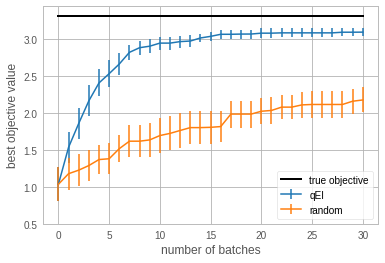

In [13]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

iters = np.arange(N_BATCH+1)
y_ei = np.asarray(best_observed_ei_all)
y_rnd = np.asarray(best_random_all)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.errorbar(iters, y_ei.mean(axis=0), yerr=1.96*y_ei.std(axis=0)/np.sqrt(N_TRIALS), label="qEI", linewidth=1.5)
ax.errorbar(iters, y_rnd.mean(axis=0), yerr=1.96*y_rnd.std(axis=0)/np.sqrt(N_TRIALS), label="random", linewidth=1.5)
plt.plot([0, N_BATCH], [MAX_VAL]*2, 'k', label="true objective", linewidth=2)
ax.set_ylim(bottom=0.5)
ax.set(xlabel='number of batches', ylabel='best objective value')
ax.legend(loc="lower right")